In [17]:
!pwd

/home/sasha/effective-inference/notebooks


In [18]:
import pandas as pd
import timeit
import matplotlib.pyplot as plt
import json
from scipy.stats import entropy
from collections import Counter
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns

# First results

In [60]:
code_lama_line_middle = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1704720471.0476246.csv', index_col = 0)
code_lama_line = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1705033319.5332122.csv',index_col = 0)
code_lama_next_word_middle = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706227486.3862705.csv',index_col = 0)
# code_lama_next_word_middle = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1704698178.7878275.csv', index_col = 0)
# code_lama_next_word = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1704662673.1772642.csv', index_col = 0)
code_lama_next_word = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1705282161.266259.csv', index_col = 0)


In [61]:

line_logits = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706199725.2579572.csv',index_col = 0)
next_word_middle_logits = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706194377.279035.csv',index_col = 0)
next_word_logits = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1705938359.1197608.csv', index_col = 0)

In [62]:
logs = [line_logits, next_word_middle_logits, next_word_logits]
for n, i in enumerate([ code_lama_line, code_lama_next_word_middle, code_lama_next_word]):
    i['tokenised_name'] = i['tokenised_name'].apply(lambda x: list(map(int, x[2:-2].split(','))))
    i['scores'] = i['scores'].apply(lambda x: list(map(float, x[1:-1].split(','))))
    i['ids'] = i['ids'].apply(lambda x: list(map(int, x[1:-1].split(','))))
    i['line_ids'] = i['ids'].apply(lambda x: x[0: x.index(13, 1) if 13 in x[1:] else len(x) ])
    
    
    i['ids_prompt'] = logs[n]['ids'].apply(lambda x: list(map(int, str(x)[1:-1].split(','))))
    i['logits'] = logs[n]['logits'].apply(lambda x: list(map(float, str(x)[1:-1].split(','))))
    i['tokenised_name'] = logs[n]['tokenised_name'].apply(lambda x: list(map(int, x[4:-2].split(','))))
    def name_logits(x):
        return [el for i, el in enumerate(x['logits']) if x['ids_prompt'][i] in x['tokenised_name']]
    i['name_logits']  = i.apply(lambda x:name_logits(x), axis=1)
    def nonname_logits(x):
        return [el for i, el in enumerate(x['logits']) if x['ids_prompt'][i] not in x['tokenised_name']]
    i['nonname_logits']  = i.apply(lambda x:nonname_logits(x), axis=1)
    
    def app(row):
        return row['scores'][0:len(row['line_ids'])]
    i['line_scores'] = i.apply(app, axis=1)

ValueError: could not convert string to float: 'a'

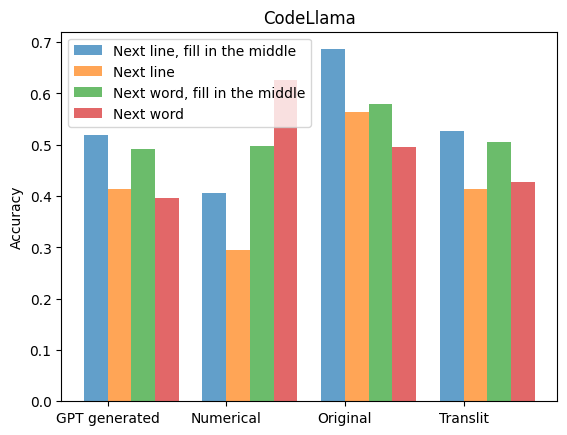

In [63]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']

data1 = dict(code_lama_line_middle.groupby('name_type')['answer'].mean())
data2 = dict(code_lama_line.groupby('name_type')['answer'].mean())
data3 = dict(code_lama_next_word_middle.groupby('name_type')['answer'].mean())
data4 = dict(code_lama_next_word.groupby('name_type')['answer'].mean())

# Plotting
bar_width = 0.2
index = range(len(categories))

plt.bar(index, data1.values(), width=bar_width, label='Next line, fill in the middle', alpha=0.7, )
plt.bar([i + bar_width for i in index], data2.values(), width=bar_width, label='Next line', alpha=0.7)
plt.bar([i + bar_width*2 for i in index], data3.values(), width=bar_width, label='Next word, fill in the middle', alpha=0.7)
plt.bar([i + bar_width*3 for i in index], data4.values(), width=bar_width, label='Next word', alpha=0.7)

# Customize plot
plt.title('CodeLlama')
plt.ylabel('Accuracy')
plt.xticks([i + bar_width / 2 for i in index], data1.keys())
plt.legend()

# Show plot
plt.show()

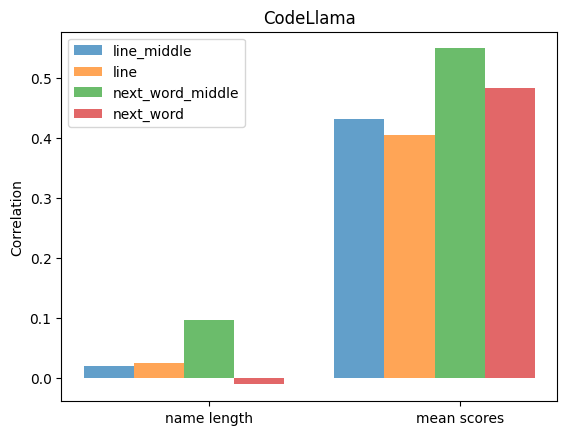

In [74]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']
data = []
for i in [code_lama_line_middle, code_lama_line, code_lama_next_word_middle, code_lama_next_word]:
    d= []
    d.append(pearsonr(i['tokenised_name'].apply(len), i['answer'])[0])
    d.append(pearsonr(i['scores'].apply(np.mean), i['answer'])[0])
    data.append(d)    

# Plotting
bar_width = 0.2
index = range(2)
datasets = ['line_middle', 'line', 'next_word_middle', 'next_word']
for i, d in enumerate(data):
    plt.bar([t + bar_width*i for t in index], d, width=bar_width, label=datasets[i], alpha=0.7, )
    
# Customize plot
plt.title('CodeLlama')
plt.ylabel('Correlation')
plt.xticks([i+bar_width*2 for i in index], ['name length', 'mean scores'])
plt.legend()

# Show plot
plt.show()

In [275]:
next_word_logits.head()

,name_type,prompt,function_name,generated,logits,ids,tokenised_name
0,Original,"def str(val):\n """"""Convert float to string,...",str,NaN,"[-13.5, 3.931640625, 3.73046875, -0.830078125,...","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[[1, 851]]"
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,NaN,"[-13.46875, 4.01171875, 3.90625, 2.48828125, 2...","[1, 822, 15068, 29918, 28327, 29918, 7411, 299...","[[1, 15068, 29918, 28327, 29918, 7411, 29918, ..."
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0,NaN,"[-13.4453125, 3.9609375, -0.1131591796875, 10....","[1, 822, 29871, 29900, 29898, 791, 1125, 13, 1...","[[1, 29871, 29900]]"
3,Translit,"def stroka(val):\n """"""Convert float to stri...",stroka,NaN,"[-13.4453125, 3.99609375, 2.994140625, 0.26489...","[1, 822, 23351, 1335, 29898, 791, 1125, 13, 16...","[[1, 23351, 1335]]"
4,Original,"def str(val):\n """"""Convert float to string,...",colnum2name,NaN,"[-13.4765625, 3.931640625, 3.70703125, -0.7797...","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[[1, 784, 1949, 29906, 978]]"


In [65]:
next_word_logits = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1705938359.1197608.csv', index_col = 0)
next_word_logits['tokenised_name'] = next_word_logits['tokenised_name'].apply(lambda x: list(map(int, x[4:-2].split(','))))
next_word_logits['logits'] = next_word_logits['logits'].apply(lambda x: list(map(float, x[1:-1].split(','))))
next_word_logits['ids'] = next_word_logits['ids'].apply(lambda x: list(map(int, x[1:-1].split(','))))

next_word = code_lama_next_word

next_word['ids_prompt'] = next_word_logits['ids']
next_word['logits'] = next_word_logits['logits']
next_word['tokenised_name'] = next_word_logits['tokenised_name']
def name_logits(x):
    return [el for i, el in enumerate(x['logits']) if x['ids_prompt'][i] in x['tokenised_name']]
next_word['name_logits']  = next_word.apply(lambda x:name_logits(x), axis=1)
def nonname_logits(x):
    return [el for i, el in enumerate(x['logits']) if x['ids_prompt'][i] not in x['tokenised_name']]
next_word['nonname_logits']  = next_word.apply(lambda x:nonname_logits(x), axis=1)
next_word.head()

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,ids_prompt,logits,name_logits,nonname_logits
0,Original,"def str(val):\n """"""Convert float to string,...",str,str(y),str(y)\n,True,"[16.53125, 20.796875, 20.03125, 20.15625, 22.5]","[851, 29898, 29891, 29897, 13]",[851],"[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[-13.5, 3.931640625, 3.73046875, -0.830078125,...",[3.73046875],"[-13.5, 3.931640625, -0.830078125, 3.80078125,..."
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,locale_aware_float_to_string(y),str(y)\n,False,"[16.765625, 21.890625, 20.625, 20.34375, 22.6875]","[851, 29898, 29891, 29897, 13]","[15068, 29918, 28327, 29918, 7411, 29918, 517,...","[1, 822, 15068, 29918, 28327, 29918, 7411, 299...","[-13.46875, 4.01171875, 3.90625, 2.48828125, 2...","[3.90625, 2.48828125, 2.78125, 4.484375, 5.562...","[-13.46875, 4.01171875, 0.62890625, 5.765625, ..."
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0,0(y),0(y)\n,True,"[21.0625, 20.453125, 21.46875, 20.640625, 21.6...","[29900, 29898, 29891, 29897, 13]","[29871, 29900]","[1, 822, 29871, 29900, 29898, 791, 1125, 13, 1...","[-13.4453125, 3.9609375, -0.1131591796875, 10....","[-0.1131591796875, 10.6953125, 0.408935546875,...","[-13.4453125, 3.9609375, -1.609375, 3.73046875..."
3,Translit,"def stroka(val):\n """"""Convert float to stri...",stroka,stroka(y),str(y)\n,False,"[15.0078125, 20.09375, 19.765625, 19.796875, 2...","[851, 29898, 29891, 29897, 13]","[23351, 1335]","[1, 822, 23351, 1335, 29898, 791, 1125, 13, 16...","[-13.4453125, 3.99609375, 2.994140625, 0.26489...","[2.994140625, 0.264892578125, 0.9130859375, -0...","[-13.4453125, 3.99609375, -0.51318359375, 1.95..."
4,Original,"def str(val):\n """"""Convert float to string,...",colnum2name,colnum2name(x) + str(y),"""%s%d"" % (colnum2name(x), y)\n",False,"[18.15625, 20.78125, 21.640625, 19.71875, 22.3...","[11860, 29879, 29995, 29881, 29908, 1273, 313,...","[784, 1949, 29906, 978]","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[-13.4765625, 3.931640625, 3.70703125, -0.7797...","[7.0234375, 0.11083984375, 8.359375, 6.0273437...","[-13.4765625, 3.931640625, 3.70703125, -0.7797..."


In [277]:
print(next_word['prompt'].iloc[0])

def str(val):
    """Convert float to string, taking the locale into account."""
    return _format("%.12g", val)

def colnum2name(n):
    "Translate a column number to name (e.g. 1->'A', etc.)."
    assert n > 0
    s = ""
    while n:
        n, m = divmod(n-1, 26)
        s = chr(m+ord('A')) + s
    return s
def cellname(x, y):
    "Translate a cell coordinate to a fancy cell name (e.g. (1, 1)->'A1')."
    assert x > 0 # Column 0 has an empty name, so can't use that
    return colnum2name(x) + <FILL_ME>


In [278]:
print(next_word['ids'].iloc[0])

[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995, 18455, 5785, 304, 1347, 29892, 5622, 278, 15068, 964, 3633, 1213, 15945, 13, 1678, 736, 903, 4830, 11702, 29889, 29896, 29906, 29887, 613, 659, 29897, 13, 13, 1753, 784, 1949, 29906, 978, 29898, 29876, 1125, 13, 1678, 376, 4300, 9632, 263, 1897, 1353, 304, 1024, 313, 29872, 29889, 29887, 29889, 29871, 29896, 976, 29915, 29909, 742, 2992, 6250, 29908, 13, 1678, 4974, 302, 1405, 29871, 29900, 13, 1678, 269, 353, 5124, 13, 1678, 1550, 302, 29901, 13, 4706, 302, 29892, 286, 353, 1933, 1545, 29898, 29876, 29899, 29896, 29892, 29871, 29906, 29953, 29897, 13, 4706, 269, 353, 18460, 29898, 29885, 29974, 536, 877, 29909, 8785, 718, 269, 13, 1678, 736, 269, 13, 1753, 3038, 978, 29898, 29916, 29892, 343, 1125, 13, 1678, 376, 4300, 9632, 263, 3038, 14821, 304, 263, 19231, 3038, 1024, 313, 29872, 29889, 29887, 29889, 313, 29896, 29892, 29871, 29896, 19969, 29915, 29909, 29896, 2824, 29908, 13, 1678, 4974, 921, 1405, 29871, 29900, 396, 12481, 29871, 29

In [279]:
print(next_word['logits'].iloc[0])

[-13.5, 3.931640625, 3.73046875, -0.830078125, 3.80078125, 0.84423828125, 12.7109375, 2.01953125, 6.609375, -3.677734375, 6.2265625, 6.38671875, 7.0546875, 1.384765625, 2.33203125, 5.73828125, 8.859375, 7.98828125, 1.8994140625, 7.23828125, 12.7890625, 16.765625, 1.51953125, 4.5546875, 0.59228515625, 5.234375, 2.115234375, 1.71875, 13.6796875, 7.046875, 3.70703125, 2.626953125, 1.630859375, -0.457275390625, 19.1875, 17.359375, -5.9375, 0.1993408203125, 8.5234375, 6.04296875, 2.12109375, 1.0869140625, 5.01171875, 1.9619140625, 15.5703125, 1.7421875, 4.31640625, -0.84423828125, -5.13671875, 7.04296875, 9.1328125, 9.265625, 7.15234375, 6.75390625, 0.93896484375, 0.90966796875, 7.03125, 1.138671875, 1.32421875, 2.99609375, 11.171875, 4.47265625, 3.3515625, 3.34375, -1.6962890625, 7.9296875, -6.3046875, 7.41796875, 19.40625, 1.86328125, 3.64453125, 1.384765625, 5.29296875, 5.0703125, 6.2734375, 19.0, 1.2763671875, 1.7021484375, 2.66796875, 8.03125, 17.828125, 2.21484375, 4.3671875, 2.384765

In [195]:
next_word['group'] = next_word.index // 4  # Integer division by 4


In [196]:
next_word.head()

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,line_ids,line_scores,logits,prob,ids_prompt,name_logits,nonname_logits,target,group
0,Original,"def str(val):\n """"""Convert float to string,...",str,str(y),str(y)\n,True,"[16.53125, 20.796875, 20.03125, 20.15625, 22.5]","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...",[851],"[851, 29898, 29891, 29897]","[16.53125, 20.796875, 20.03125, 20.15625]","[-13.5, 3.931640625, 3.73046875, -0.830078125,...","[1.3709572068578448e-06, 0.980765741038007, 0....","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...",[3.73046875],"[-13.5, 3.931640625, -0.830078125, 3.80078125,...",4.764802,0
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,locale_aware_float_to_string(y),str(y)\n,False,"[16.765625, 21.890625, 20.625, 20.34375, 22.6875]","[1, 822, 15068, 29918, 28327, 29918, 7411, 299...","[15068, 29918, 28327, 29918, 7411, 29918, 517,...","[851, 29898, 29891, 29897]","[16.765625, 21.890625, 20.625, 20.34375]","[-13.46875, 4.01171875, 3.90625, 2.48828125, 2...","[1.4144759985825913e-06, 0.9822196099268891, 0...","[1, 822, 15068, 29918, 28327, 29918, 7411, 299...","[3.90625, 2.48828125, 2.78125, 4.484375, 5.562...","[-13.46875, 4.01171875, 0.62890625, 5.765625, ...",4.841567,0
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0,0(y),0(y)\n,True,"[21.0625, 20.453125, 21.46875, 20.640625, 21.6...","[1, 822, 29871, 29900, 29898, 791, 1125, 13, 1...","[29871, 29900]","[29900, 29898, 29891, 29897]","[21.0625, 20.453125, 21.46875, 20.640625]","[-13.4453125, 3.9609375, -0.1131591796875, 10....","[1.448019281668024e-06, 0.9813106915732508, 0....","[1, 822, 29871, 29900, 29898, 791, 1125, 13, 1...","[-0.1131591796875, 10.6953125, 0.408935546875,...","[-13.4453125, 3.9609375, -1.609375, 3.73046875...",4.780726,0
3,Translit,"def stroka(val):\n """"""Convert float to stri...",stroka,stroka(y),str(y)\n,False,"[15.0078125, 20.09375, 19.765625, 19.796875, 2...","[1, 822, 23351, 1335, 29898, 791, 1125, 13, 16...","[23351, 1335]","[851, 29898, 29891, 29897]","[15.0078125, 20.09375, 19.765625, 19.796875]","[-13.4453125, 3.99609375, 2.994140625, 0.26489...","[1.448019281668024e-06, 0.9819446650265006, 0....","[1, 822, 23351, 1335, 29898, 791, 1125, 13, 16...","[2.994140625, 0.264892578125, 0.9130859375, -0...","[-13.4453125, 3.99609375, -0.51318359375, 1.95...",4.334899,0
4,Original,"def str(val):\n """"""Convert float to string,...",colnum2name,colnum2name(x) + str(y),"""%s%d"" % (colnum2name(x), y)\n",False,"[18.15625, 20.78125, 21.640625, 19.71875, 22.3...","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[784, 1949, 29906, 978]","[11860, 29879, 29995, 29881, 29908, 1273, 313,...","[18.15625, 20.78125, 21.640625, 19.71875, 22.3...","[-13.4765625, 3.931640625, 3.70703125, -0.7797...","[1.4034684744809525e-06, 0.980765741038007, 0....","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[7.0234375, 0.11083984375, 8.359375, 6.0273437...","[-13.4765625, 3.931640625, 3.70703125, -0.7797...",4.872467,1


In [97]:
pearsonr(next_word['scores'].apply(np.mean), next_word['answer'])

PearsonRResult(statistic=0.48269133645400514, pvalue=5.843112682352003e-258)

In [242]:
pearsonr(next_word['name_logits'].apply(np.mean), next_word['answer'])

PearsonRResult(statistic=0.03508509441212785, pvalue=0.01939254121883814)

In [174]:
next_word['target']= next_word['name_logits'].apply(np.mean)

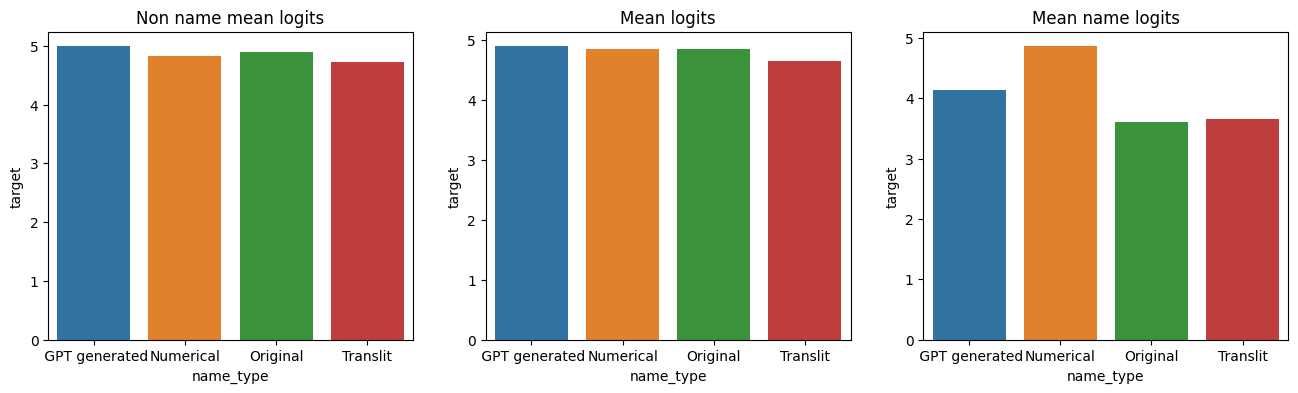

In [67]:
next_word['target'] = next_word['name_logits'].apply(np.mean)
data1 = next_word.groupby('name_type')['target'].mean().reset_index()

f, a = plt.subplots(1, 3, figsize=(16, 4))

next_word['target'] = next_word['nonname_logits'].apply(np.mean)
data = next_word.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[0])
a[0].set_title('Non name mean logits')

next_word['target'] = next_word['logits'].apply(np.mean)
data = next_word.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[1])
a[1].set_title('Mean logits')

next_word['target'] = next_word['name_logits'].apply(np.mean)
data = next_word.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[2])
a[2].set_title('Mean name logits')
# Showing the plot
plt.show()

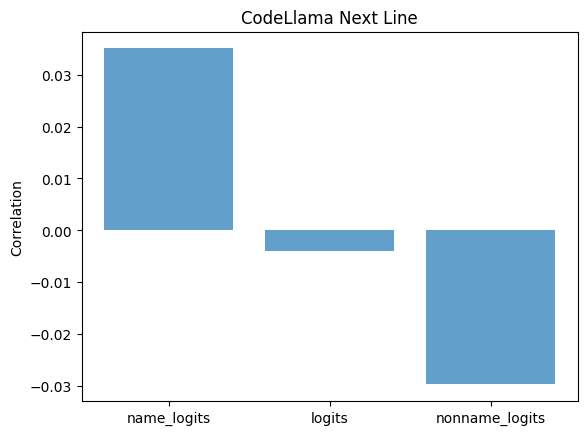

In [69]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']
d= []
features = ['name_logits', 'logits', 'nonname_logits']
for i in features:
    d.append(pearsonr(next_word[i].apply(np.mean), next_word['answer'])[0])
    
index = range(3)
plt.bar(index, d, alpha=0.7)
    
# Customize plot
plt.title('CodeLlama Next Line')
plt.ylabel('Correlation')
plt.xticks(index, features)

# Show plot
plt.show()

In [198]:
grouped = next_word.groupby('group')

In [199]:
grouped

In [240]:
def calculate_difference(group):
    first_row_value = np.mean(group.iloc[0]['nonname_logits'])
    # print(group['logits'])
    group['difference'] = group['nonname_logits'].apply(np.mean) - first_row_value
    return group

df_difference = next_word.groupby('group').apply(calculate_difference).drop(['group'], axis=1).reset_index().drop(['level_1'], axis=1)

/tmp/ipykernel_23747/1518299970.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_difference = next_word.groupby('group').apply(calculate_difference).drop(['group'], axis=1).reset_index().drop(['level_1'], axis=1)


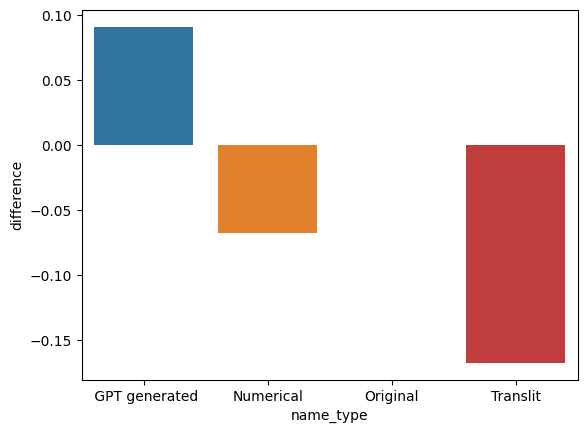

In [241]:
data = df_difference.groupby('name_type')['difference'].mean().reset_index()

sns.barplot(x='name_type', y='difference', data=data)
plt.show()

In [22]:
line_probs = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706519683.9933228.csv', index_col = 0)


In [124]:
next_line.to_csv('/home/sasha/effective-inference/clean_naming/next_line_all_data.csv')

In [66]:
line_probs = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706519683.9933228.csv', index_col = 0)
line_probs['tokenised_name'] = line_probs['tokenised_name'].apply(lambda x: list(map(int, x[4:-2].split(','))))
line_probs['probs'] = line_probs['probs'].apply(lambda x: list(map(float, x[1:-1].split(','))))
line_probs['ids'] = line_probs['ids'].apply(lambda x: list(map(int, x[1:-1].split(','))))

next_line = code_lama_line

next_line['ids_prompt'] = line_probs['ids']
next_line['probs'] = line_probs['probs']
next_line['tokenised_name'] = line_probs['tokenised_name']
def name_probs(x):
    return [el for i, el in enumerate(x['probs']) if x['ids_prompt'][i] in x['tokenised_name']]
next_line['name_probs']  = next_line.apply(lambda x:name_probs(x), axis=1)
def nonname_probs(x):
    return [el for i, el in enumerate(x['probs']) if x['ids_prompt'][i] not in x['tokenised_name']]
next_line['nonname_probs']  = next_line.apply(lambda x:nonname_probs(x), axis=1)

next_line.head()

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,line_ids,ids_prompt,probs,name_probs,nonname_probs
0,Original,"def str(val):\n """"""Convert float to string,...",str,return colnum2name(x) + str(y),return colnum2name(x) + str(y),True,"[24.109375, 18.203125, 19.09375, 22.8125, 25.2...","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...",[851],"[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[1, 32007, 822, 851, 29898, 791, 1125, 13, 167...","[1.824138171242773e-13, 8.889663149602711e-06,...",[5.6465919442416634e-06],"[1.824138171242773e-13, 8.889663149602711e-06,..."
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,return convert_column_number_to_name(x) + ...,assert y > 0,False,"[23.84375, 18.15625, 19.921875, 19.28125, 23.5...","[1678, 4974, 343, 1405, 29871, 29900, 13, 1678...","[15068, 29918, 28327, 29918, 7411, 29918, 517,...","[1678, 4974, 343, 1405, 29871, 29900]","[1, 32007, 822, 15068, 29918, 28327, 29918, 74...","[1.694665187259442e-13, 8.523251381120645e-06,...","[4.0546456148149446e-05, 6.608235594285361e-07...","[1.694665187259442e-13, 8.523251381120645e-06,..."
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0,return 1(x) + 0(y),"return ""%s%d"" % (1(x), y)",False,"[23.171875, 18.359375, 17.328125, 20.46875, 20...","[1678, 736, 11860, 29879, 29995, 29881, 29908,...","[29871, 29900]","[1678, 736, 11860, 29879, 29995, 29881, 29908,...","[1, 32007, 822, 29871, 29900, 29898, 791, 1125...","[1.8027221967802098e-13, 7.426019237755099e-06...","[8.357615399745555e-08, 0.04009966179728508, 2...","[1.8027221967802098e-13, 7.426019237755099e-06..."
3,Translit,"def stroka(val):\n """"""Convert float to stri...",stroka,return kolonka_v_imya(x) + stroka(y),return kolonka_v_imya(x) + str(y),False,"[23.46875, 17.484375, 17.6875, 23.375, 25.0, 2...","[1678, 736, 14276, 265, 1335, 29918, 29894, 29...","[23351, 1335]","[1678, 736, 14276, 265, 1335, 29918, 29894, 29...","[1, 32007, 822, 23351, 1335, 29898, 791, 1125,...","[2.0253114777716436e-13, 9.92044442682527e-06,...","[6.9284660639823414e-06, 1.174421186078689e-06...","[2.0253114777716436e-13, 9.92044442682527e-06,..."
4,Original,"def str(val):\n """"""Convert float to string,...",colnum2name,return colnum2name(x) + str(y),return colnum2name(x) + str(y),True,"[24.109375, 18.203125, 19.09375, 22.8125, 25.2...","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[784, 1949, 29906, 978]","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[1, 32007, 822, 851, 29898, 791, 1125, 13, 167...","[1.824138171242773e-13, 8.889663149602711e-06,...","[1.7310953808191698e-06, 1.950041479403808e-07...","[1.824138171242773e-13, 8.889663149602711e-06,..."


In [55]:
def mid_prob(x):
    return x['probs'][x['ids_prompt'].index(32009)] if 32009 in x['ids_prompt'] else 0
next_line['mid_prob']  = next_line.apply(lambda x:mid_prob(x), axis=1)

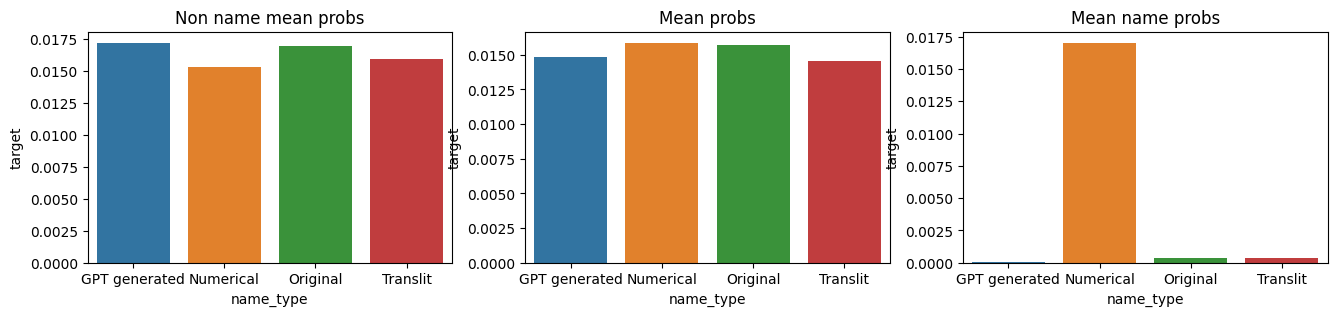

In [58]:
next_line['target'] = next_line['name_probs'].apply(np.mean)
data1 = next_line.groupby('name_type')['target'].mean().reset_index()

f, a = plt.subplots(1, 3, figsize=(16, 3))

next_line['target'] = next_line['nonname_probs'].apply(np.mean)
data = next_line.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[0])
a[0].set_title('Non name mean probs')

next_line['target'] = next_line['probs'].apply(np.mean)
data = next_line.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[1])
a[1].set_title('Mean probs')

next_line['target'] = next_line['name_probs'].apply(np.mean)
data = next_line.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[2])
a[2].set_title('Mean name probs')
# Showing the plot
plt.show()

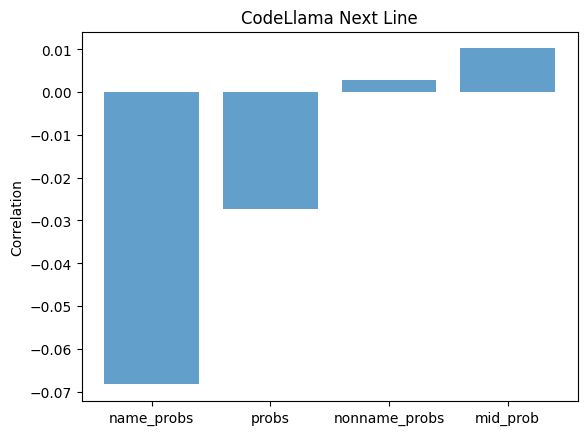

In [57]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']
d= []
features = ['name_probs', 'probs', 'nonname_probs', 'mid_prob']
for i in features:
    d.append(pearsonr(next_line[i].apply(np.mean), next_line['answer'])[0])

d.append(pearsonr(next_line[i].apply(np.mean), next_line['answer'])[0])
   

# Plotting

index = range(4)
plt.bar(index, d, alpha=0.7)
    
# Customize plot
plt.title('CodeLlama Next Line')
plt.ylabel('Correlation')
plt.xticks(index, features)

# Show plot
plt.show()

In [41]:
from transformers import LlamaForCausalLM, CodeLlamaTokenizer, StoppingCriteria, StoppingCriteriaList
MODEL_NAME = "codellama/CodeLlama-7b-hf"
tokenizer = CodeLlamaTokenizer.from_pretrained(MODEL_NAME)

In [51]:
next_line.iloc[0]['ids_prompt'][-5:]

[2824, 29908, 32008, 13, 32009]

In [54]:
tokenizer.decode(next_line.iloc[0]['ids_prompt'])

'<s>▁<PRE> def str(val):\n    """Convert float to string, taking the locale into account."""\n    return _format("%.12g", val)\n\ndef colnum2name(n):\n    "Translate a column number to name (e.g. 1->\'A\', etc.)."\n    assert n > 0\n    s = ""\n    while n:\n        n, m = divmod(n-1, 26)\n        s = chr(m+ord(\'A\')) + s\n    return s\ndef cellname(x, y):\n    "Translate a cell coordinate to a fancy cell name (e.g. (1, 1)->\'A1\')."▁<SUF>\n▁<MID>'

In [73]:
pearsonr(next_line['name_probs'].apply(np.mean), next_line['scores'].apply(np.mean))[0]

-0.05589486365633092

In [121]:
pearsonr(next_line['mean_name_scores'].fillna(0), next_line['answer'])[0]

0.5514682258413527

In [94]:
next_line['mean_name_scores'] = next_line['name_scores'].apply(np.mean)

/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [117]:
n_1_indexes = next_line[(next_line['answer']==0) & (next_line['name_type']=='Original')].index
next_line.loc[n_1_indexes +3][next_line['answer'] == 1].shape

/tmp/ipykernel_244377/732598848.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  next_line.loc[n_1_indexes +3][next_line['answer'] == 1].shape


(19, 18)

/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sasha/.cac

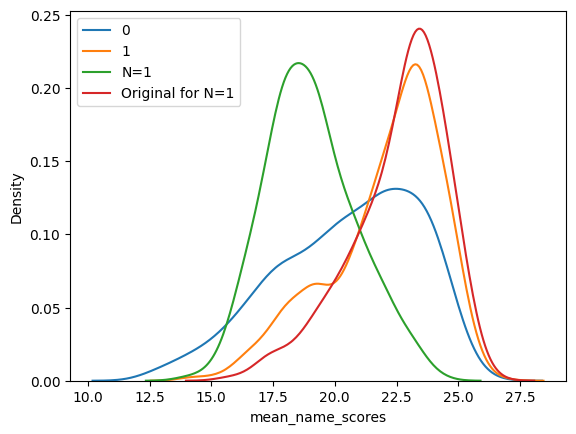

In [109]:

sns.kdeplot(data=next_line[next_line['answer']==0], x="mean_name_scores",  label = '0')
sns.kdeplot(data=next_line[next_line['answer']==1], x="mean_name_scores", label = '1')
sns.kdeplot(data=next_line[(next_line['answer']==1) & (next_line['name_type']=='Numerical')], x="mean_name_scores", label = 'N=1')
sns.kdeplot(next_line.loc[n_1_indexes - 2], x="mean_name_scores", label = 'Original for N=1')

plt.legend()
# plt.xlim(10,21)

In [90]:
def name_probs(x):
    return [el for i, el in enumerate(x['scores']) if x['ids'][i] in x['tokenised_name']]
next_line['name_scores']  = next_line.apply(lambda x:name_probs(x), axis=1)

In [93]:
len(next_line.iloc[0]['ids'])

20

/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(-0.05, 0.05)

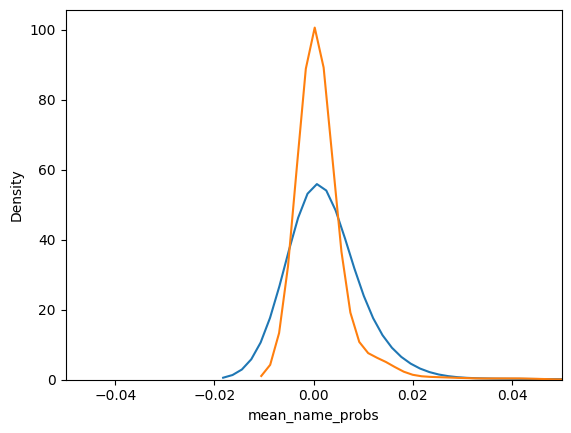

In [84]:

sns.kdeplot(data=next_line[next_line['answer']==0], x="mean_name_probs")
sns.kdeplot(data=next_line[next_line['answer']==1], x="mean_name_probs")
plt.xlim(-0.05,0.05)

/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='mean_name_probs', ylabel='Density'>

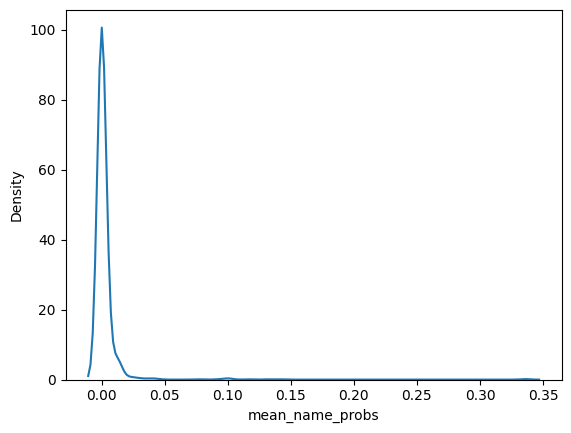

In [81]:
sns.kdeplot(data=next_line[next_line['answer']==1], x="mean_name_probs")